# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_Aging3_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for Aging3 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_Aging3_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# Aging3_twas = fread("~/project/image_QTL/twas/multiple_testing/image_Aging3_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
Aging3_twas = fread("~/project/image_QTL/twas/image_Aging3_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [5]:
# weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [6]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- Aging3_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [7]:
head(Aging3_twas)
dim(Aging3_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,enet,TRUE,FALSE,0.098757440,8.923911e-10,0.9022919,0.3669019,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,lasso,TRUE,FALSE,0.103370596,3.541036e-10,0.8315505,0.4056627,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,mrash,TRUE,FALSE,0.089177838,6.013310e-09,1.0668278,0.2860496,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_Aging3,susie,TRUE,TRUE,0.121638427,8.766557e-12,0.9338231,0.3503952,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging3,enet,TRUE,FALSE,0.007872702,5.201216e-02,-1.5674767,0.1170033,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_Aging3,lasso,TRUE,FALSE,0.006195072,7.447581e-02,-1.5819370,0.1136639,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 924774     19

In [8]:
# Strong and reliable TWAS signals:
Aging3_twas_filtered <- Aging3_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
Aging3_block = unique(Aging3_twas_filtered$block)

In [9]:
dim(Aging3_twas_filtered)

[1] 181  19

In [1]:
# R Script to Process TWAS/SuSiE Fine-mapping Results Across Multiple Cohorts
# MULTI-COHORT CONTEXT-AWARE VERSION with hierarchical credible set selection
# Processes each cohort-block-context combination separately to identify context-specific top variants

# Step 1: Load necessary libraries
library(purrr)
library(stringr)
library(data.table)
library(dplyr)

# --- Helper Function for Hierarchical Variant Selection ---
select_top_variant_hierarchical <- function(df, gene_id) {
    # Select the top variant using hierarchical credible set coverage criteria.
    # Priority: cs_coverage_0.95 > cs_coverage_0.7 > cs_coverage_0.5 > highest PIP
    # 
    # Args:
    #   df: Data frame containing variant information with PIP and coverage columns
    #   gene_id: Gene identifier for messaging purposes
    # 
    # Returns:
    #   Single-row data frame with the selected top variant and selection method
    
    if (nrow(df) == 0) {
        warning(paste("No variants found for gene:", gene_id))
        return(NULL)
    }
    
    # Initialize selection method tracking
    selection_method <- "unknown"
    top_variant_df <- NULL
    
    # Level 1: Check for variants with cs_coverage_0.95 > 0
    variants_95 <- df |> filter(cs_coverage_0.95 > 0)
    if (nrow(variants_95) > 0) {
        top_variant_df <- variants_95 |>
            arrange(desc(pip)) |>
            dplyr::slice(1)
        selection_method <- "cs_coverage_0.95"
        message(paste("Gene", gene_id, ": Selected variant based on cs_coverage_0.95 >0, n_candidates =", nrow(variants_95)))
    } else {
        # Level 2: Check for variants with cs_coverage_0.7 > 0
        variants_70 <- df |> filter(cs_coverage_0.7 > 0)
        if (nrow(variants_70) > 0) {
            top_variant_df <- variants_70 |>
                arrange(desc(pip)) |>
                dplyr::slice(1)
            selection_method <- "cs_coverage_0.7"
            message(paste("Gene", gene_id, ": Selected variant based on cs_coverage_0.7 >0, n_candidates =", nrow(variants_70)))
        } else {
            # Level 3: Check for variants with cs_coverage_0.5 > 0
            variants_50 <- df |> filter(cs_coverage_0.5 > 0)
            if (nrow(variants_50) > 0) {
                top_variant_df <- variants_50 |>
                    arrange(desc(pip)) |>
                    dplyr::slice(1)
                selection_method <- "cs_coverage_0.5"
                message(paste("Gene", gene_id, ": Selected variant based on cs_coverage_0.5 >0, n_candidates =", nrow(variants_50)))
            } else {
                # Level 4: Fall back to highest PIP among all variants
                top_variant_df <- df |>
                    arrange(desc(pip)) |>
                    dplyr::slice(1)
                selection_method <- "no_cs"
                message(paste("Gene", gene_id, ": No credible set coverage >0 found, selected highest PIP variant, n_total =", nrow(df)))
            }
        }
    }
    
    # Add selection method information to the result
    if (!is.null(top_variant_df)) {
        top_variant_df$selection_method <- selection_method
        top_variant_df$n_total_variants <- nrow(df)
    }
    
    return(top_variant_df)
}

# --- Define Cohort Information ---
cohorts <- list(
    KNIGHT = list(
        name = "KNIGHT",
        weight_db_path = "~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    MSBB = list(
        name = "MSBB", 
        weight_db_path = "~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP = list(
        name = "ROSMAP",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP_MEGA = list(
        name = "ROSMAP_MEGA",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv"
    )
)

# --- Main Processing Logic ---

# Initialize master list to store results from all cohorts
all_cohorts_results <- list()
master_processing_summary <- list(
    cohorts_processed = 0,
    total_regions = 0,
    total_contexts = 0,
    total_genes_processed = 0,
    genes_with_weights = 0,
    genes_with_credible_sets = 0,
    errors = character(0)
)

cat("=== Starting Multi-Cohort Context-Aware TWAS/SuSiE Processing ===\n")
cat("Cohorts to process:", length(cohorts), "\n")
cat("Cohort names:", paste(names(cohorts), collapse = ", "), "\n")
cat("Total regions per cohort:", length(Aging3_block), "\n\n")

# Loop through each cohort
for (cohort_idx in seq_along(cohorts)) {
    cohort_info <- cohorts[[cohort_idx]]
    cohort_name <- cohort_info$name
    weight_db_path <- cohort_info$weight_db_path
    
    cat(sprintf("=== PROCESSING COHORT %d/%d: %s ===\n", cohort_idx, length(cohorts), cohort_name))
    
    # Initialize cohort-specific tracking
    cohort_results <- list()
    cohort_summary <- list(
        cohort_name = cohort_name,
        total_regions = 0,
        total_contexts = 0,
        total_genes_processed = 0,
        genes_with_weights = 0,
        genes_with_credible_sets = 0,
        errors = character(0)
    )
    
    tryCatch({
        # Load weight database list for current cohort
        cat(sprintf("Loading weight database metadata: %s\n", weight_db_path))
        weight_db_list <- fread(weight_db_path)
        cat(sprintf("Loaded %d weight database entries for %s\n", nrow(weight_db_list), cohort_name))
        
        master_processing_summary$cohorts_processed <- master_processing_summary$cohorts_processed + 1
        
        # Loop through each specified region/block
        for (region_idx in seq_along(Aging3_block)) {
            region_db <- Aging3_block[region_idx]
            cohort_summary$total_regions <- cohort_summary$total_regions + 1
            
            cat(sprintf("  Processing region %d/%d: %s\n", region_idx, length(Aging3_block), region_db))
            
            tryCatch({
                # Filter for significant genes within the current block
                Aging3_multigene_per_block <- Aging3_twas_filtered |> 
                    filter(block == region_db)
                
                n_sig_genes <- length(unique(Aging3_multigene_per_block$molecular_id))
                contexts_in_region <- unique(Aging3_multigene_per_block$context)
                cohort_summary$total_contexts <- cohort_summary$total_contexts + length(contexts_in_region)
                
                cat(sprintf("    Found %d significant genes across %d contexts in region %s\n", 
                           n_sig_genes, length(contexts_in_region), region_db))
                cat(sprintf("    Contexts: %s\n", paste(contexts_in_region, collapse = ", ")))
                
                if (n_sig_genes == 0) {
                    cat("    No significant genes found, skipping region\n")
                    next
                }
                
                # Loop through each context in the region
                for (context_name in contexts_in_region) {
                    cat(sprintf("      Processing context: %s\n", context_name))
                    
                    # Filter for genes in this specific context
                    genes_in_context <- Aging3_multigene_per_block |> 
                        filter(context == context_name) |> 
                        pull(molecular_id) |> 
                        unique()
                    
                    cat(sprintf("        %d genes in this context\n", length(genes_in_context)))
                    
                    # Loop through each gene in the current context
                    for (gene_idx in seq_along(genes_in_context)) {
                        gene_db <- genes_in_context[gene_idx]
                        cohort_summary$total_genes_processed <- cohort_summary$total_genes_processed + 1
                        
                        cat(sprintf("          Processing gene %d/%d: %s\n", gene_idx, length(genes_in_context), gene_db))
                        
                        tryCatch({
                            # Get the database paths for the weights
                            weight_db_matches <- weight_db_list |> filter(region_id == gene_db)
                            
                            if (nrow(weight_db_matches) == 0) {
                                warning(paste("No weight database found for gene:", gene_db, "in cohort:", cohort_name))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No weight DB for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            weight_dbs <- weight_db_matches |> 
                                pull(original_data) |> 
                                str_split(",") |> 
                                unlist()
                            
                            cat(sprintf("            Loading weights from %d database(s)\n", length(weight_dbs)))
                            
                            # Load the weights for the current gene
                            twas_weights_results <- load_twas_weights(
                                weight_dbs, 
                                variable_name_obj = "variant_names", 
                                susie_obj = "susie_weights_intermediate",
                                twas_weights_table = "twas_weights"
                            )
                            
                            # Enhanced validation of results
                            if (!is.list(twas_weights_results)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": load_twas_weights() did not return a list"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Non-list result for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (is.null(twas_weights_results$susie_results)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": No susie_results in weights output"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No susie_results for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (length(twas_weights_results$susie_results) == 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Empty susie_results list"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Empty susie_results for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            cohort_summary$genes_with_weights <- cohort_summary$genes_with_weights + 1
                            susie_res <- twas_weights_results$susie_results[[1]]
                            
                            # Check if top_loci exists and has data
                            if (is.null(susie_res$top_loci)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": No top_loci in susie results"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("No top_loci for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            if (nrow(susie_res$top_loci) == 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Empty top_loci data frame"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Empty top_loci for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            df <- as.data.frame(susie_res$top_loci)
                            cat(sprintf("            Found %d variants in top_loci\n", nrow(df)))
                            
                            # Validate required columns
                            required_cols <- c("pip", "cs_coverage_0.95", "cs_coverage_0.7", "cs_coverage_0.5")
                            missing_cols <- setdiff(required_cols, colnames(df))
                            if (length(missing_cols) > 0) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Missing required columns:", paste(missing_cols, collapse = ", ")))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Missing columns for gene:", gene_db, "context:", context_name, "cohort:", cohort_name, "-", paste(missing_cols, collapse = ", ")))
                                next
                            }
                            
                            # Use hierarchical selection function
                            gene_context_cohort_id <- paste(gene_db, context_name, cohort_name, sep = "_")
                            top_variant_df <- select_top_variant_hierarchical(df, gene_context_cohort_id)
                            
                            if (is.null(top_variant_df)) {
                                warning(paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, ": Failed to select top variant"))
                                cohort_summary$errors <- c(cohort_summary$errors, 
                                                          paste("Failed variant selection for gene:", gene_db, "context:", context_name, "cohort:", cohort_name))
                                next
                            }
                            
                            # Add cohort, context, and other metadata
                            top_variant_df$gene_id <- gene_db
                            top_variant_df$block_id <- region_db
                            top_variant_df$context <- context_name
                            top_variant_df$cohort <- cohort_name
                            
                            # Create unique key for gene-context-cohort combination
                            unique_key <- paste(gene_db, context_name, cohort_name, sep = "_")
                            
                            # Store the result
                            cohort_results[[unique_key]] <- top_variant_df
                            cohort_summary$genes_with_credible_sets <- cohort_summary$genes_with_credible_sets + 1
                            
                            cat(sprintf("            ✓ Successfully processed gene %s in context %s cohort %s (method: %s)\n", 
                                       gene_db, context_name, cohort_name, top_variant_df$selection_method))
                            
                        }, error = function(e) {
                            error_msg <- paste("Gene", gene_db, "in context", context_name, "cohort", cohort_name, "error:", e$message)
                            warning(error_msg)
                            cohort_summary$errors <- c(cohort_summary$errors, error_msg)
                        })
                    }
                }
                
            }, error = function(e) {
                error_msg <- paste("Region", region_db, "in cohort", cohort_name, "error:", e$message)
                warning(error_msg)
                cohort_summary$errors <- c(cohort_summary$errors, error_msg)
            })
        }
        
        # Store cohort results and update master summary
        all_cohorts_results[[cohort_name]] <- cohort_results
        
        # Update master summary
        master_processing_summary$total_regions <- master_processing_summary$total_regions + cohort_summary$total_regions
        master_processing_summary$total_contexts <- master_processing_summary$total_contexts + cohort_summary$total_contexts
        master_processing_summary$total_genes_processed <- master_processing_summary$total_genes_processed + cohort_summary$total_genes_processed
        master_processing_summary$genes_with_weights <- master_processing_summary$genes_with_weights + cohort_summary$genes_with_weights
        master_processing_summary$genes_with_credible_sets <- master_processing_summary$genes_with_credible_sets + cohort_summary$genes_with_credible_sets
        master_processing_summary$errors <- c(master_processing_summary$errors, cohort_summary$errors)
        
        cat(sprintf("  Completed cohort %s: %d/%d genes with credible sets\n\n", 
                   cohort_name, cohort_summary$genes_with_credible_sets, cohort_summary$total_genes_processed))
        
    }, error = function(e) {
        error_msg <- paste("Cohort", cohort_name, "error:", e$message)
        warning(error_msg)
        master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
    })
}

# --- Multi-Cohort Processing Summary ---
cat("=== MULTI-COHORT PROCESSING SUMMARY ===\n")
cat("Cohorts processed:", master_processing_summary$cohorts_processed, "/", length(cohorts), "\n")
cat("Total regions processed:", master_processing_summary$total_regions, "\n")
cat("Total contexts processed:", master_processing_summary$total_contexts, "\n")
cat("Total gene-context-cohort combinations processed:", master_processing_summary$total_genes_processed, "\n")
cat("Gene-context-cohort combinations with valid weights:", master_processing_summary$genes_with_weights, "\n")
cat("Gene-context-cohort combinations with credible sets:", master_processing_summary$genes_with_credible_sets, "\n")
cat("Errors encountered:", length(master_processing_summary$errors), "\n")

# Calculate MR qualification success rate
mr_success_rate <- ifelse(master_processing_summary$total_genes_processed > 0,
                         100 * master_processing_summary$genes_with_credible_sets / master_processing_summary$total_genes_processed,
                         0)
cat(sprintf("MR qualification success rate: %.1f%% (%d/%d gene-context-cohort combinations passed all filters)\n",
           mr_success_rate, master_processing_summary$genes_with_credible_sets, master_processing_summary$total_genes_processed))

if (length(master_processing_summary$errors) > 0) {
    cat("\nError details (showing first 20):\n")
    errors_to_show <- head(master_processing_summary$errors, 20)
    for (i in seq_along(errors_to_show)) {
        cat(sprintf("  %d. %s\n", i, errors_to_show[i]))
    }
    if (length(master_processing_summary$errors) > 20) {
        cat(sprintf("  ... and %d more errors\n", length(master_processing_summary$errors) - 20))
    }
}

# --- Multi-Cohort Analysis Step ---

# Flatten all cohort results into a single list
all_results_flattened <- list()
for (cohort_name in names(all_cohorts_results)) {
    cohort_data <- all_cohorts_results[[cohort_name]]
    all_results_flattened <- c(all_results_flattened, cohort_data)
}

# Combine all top-variant data frames into a single master data frame
final_df <- bind_rows(all_results_flattened)

# Check if the final data frame is empty
if (nrow(final_df) > 0) {
    cat(sprintf("\n=== MULTI-COHORT ANALYSIS RESULTS ===\n"))
    cat(sprintf("Successfully created consolidated data frame with %d gene-context-cohort combinations\n", nrow(final_df)))
    
    # Cohort distribution summary
    cohort_dist <- final_df |>
        count(cohort, name = "n_gene_contexts") |>
        arrange(desc(n_gene_contexts))
    
    cat("\nGene-context combinations by cohort:\n")
    for (i in 1:nrow(cohort_dist)) {
        cohort <- cohort_dist$cohort[i]
        count <- cohort_dist$n_gene_contexts[i]
        cat(sprintf("  %s: %d gene-context combinations\n", cohort, count))
    }
    
    # Summary of selection methods used across all cohorts
    selection_summary <- final_df |>
        count(selection_method, cohort, name = "n_gene_contexts") |>
        arrange(cohort, desc(n_gene_contexts))
    
    cat("\nVariant selection method summary by cohort:\n")
    for (cohort_name in unique(selection_summary$cohort)) {
        cat(sprintf("  %s:\n", cohort_name))
        cohort_methods <- selection_summary |> filter(cohort == cohort_name)
        for (j in 1:nrow(cohort_methods)) {
            method <- cohort_methods$selection_method[j]
            count <- cohort_methods$n_gene_contexts[j]
            cat(sprintf("    %s: %d gene-context combinations\n", method, count))
        }
    }
    
    # Context distribution summary across all cohorts
    context_cohort_dist <- final_df |>
        count(context, cohort, name = "n_genes") |>
        arrange(context, desc(n_genes))
    
    cat("\nGenes processed by context across cohorts:\n")
    for (ctx in unique(context_cohort_dist$context)) {
        cat(sprintf("  %s:\n", ctx))
        ctx_data <- context_cohort_dist |> filter(context == ctx)
        for (k in 1:nrow(ctx_data)) {
            cohort <- ctx_data$cohort[k]
            count <- ctx_data$n_genes[k]
            cat(sprintf("    %s: %d genes\n", cohort, count))
        }
    }
    
    # Select and rename columns for the desired final format
    final_df <- final_df |>
        select(
            variant_id,
            betahat,
            sebetahat,
            gene_id,
            block_id,
            context,
            cohort,
            PIP = pip,
            cs_coverage_0.95,
            cs_coverage_0.7,
            cs_coverage_0.5,
            selection_method,
            n_total_variants
        )
    
    # Identify the most likely causal gene in each block-context-cohort combination
    most_likely_causal_genes <- final_df |>
        group_by(block_id, context, cohort) |>
        arrange(desc(PIP)) |>
        dplyr::slice(1) |>
        ungroup()
    
    cat(sprintf("\n=== Most Likely Causal Gene per Block-Context-Cohort Combination ===\n"))
    cat(sprintf("Identified %d causal genes across %d block-context-cohort combinations\n", 
               nrow(most_likely_causal_genes), 
               nrow(most_likely_causal_genes)))
    
    # Summary by cohort and context
    causal_summary <- most_likely_causal_genes |>
        count(cohort, context, name = "n_blocks") |>
        arrange(cohort, desc(n_blocks))
    
    cat("\nCausal genes identified by cohort and context:\n")
    for (cohort_name in unique(causal_summary$cohort)) {
        cat(sprintf("  %s:\n", cohort_name))
        cohort_causal <- causal_summary |> filter(cohort == cohort_name)
        for (j in 1:nrow(cohort_causal)) {
            ctx <- cohort_causal$context[j]
            count <- cohort_causal$n_blocks[j]
            cat(sprintf("    %s: %d blocks\n", ctx, count))
        }
    }
    
    # Show blocks with multiple context/cohort hits
    block_multi_hits <- most_likely_causal_genes |>
        count(block_id, name = "n_context_cohort_combinations") |>
        filter(n_context_cohort_combinations > 1) |>
        arrange(desc(n_context_cohort_combinations))
    
    if (nrow(block_multi_hits) > 0) {
        cat(sprintf("\nBlocks with causal genes in multiple context-cohort combinations:\n"))
        for (i in 1:nrow(block_multi_hits)) {
            block <- block_multi_hits$block_id[i]
            n_combo <- block_multi_hits$n_context_cohort_combinations[i]
            combos_in_block <- most_likely_causal_genes |>
                filter(block_id == block) |>
                mutate(context_cohort = paste(context, cohort, sep = "-")) |>
                pull(context_cohort) |>
                paste(collapse = ", ")
            cat(sprintf("  %s: %d combinations (%s)\n", block, n_combo, combos_in_block))
        }
    } else {
        cat("\nNo blocks found with causal genes in multiple context-cohort combinations.\n")
    }
    
    # Additional quality metrics across cohorts
    cat(sprintf("\n=== MULTI-COHORT QUALITY METRICS ===\n"))
    cat(sprintf("Overall mean PIP of selected variants: %.3f\n", mean(final_df$PIP, na.rm = TRUE)))
    cat(sprintf("Overall median PIP of selected variants: %.3f\n", median(final_df$PIP, na.rm = TRUE)))
    
    high_pip_genes <- sum(final_df$PIP > 0.8, na.rm = TRUE)
    cat(sprintf("Gene-context-cohort combinations with PIP > 0.8: %d (%.1f%%)\n", 
               high_pip_genes, 
               100 * high_pip_genes / nrow(final_df)))
    
    # Cohort-specific quality metrics
    cat("\nPIP statistics by cohort:\n")
    cohort_pip_stats <- final_df |>
        group_by(cohort) |>
        summarise(
            mean_pip = mean(PIP, na.rm = TRUE),
            median_pip = median(PIP, na.rm = TRUE),
            high_pip_count = sum(PIP > 0.8, na.rm = TRUE),
            total_combinations = n(),
            .groups = "drop"
        ) |>
        arrange(desc(mean_pip))
    
    for (i in 1:nrow(cohort_pip_stats)) {
        cohort <- cohort_pip_stats$cohort[i]
        mean_pip <- cohort_pip_stats$mean_pip[i]
        median_pip <- cohort_pip_stats$median_pip[i]
        high_pip <- cohort_pip_stats$high_pip_count[i]
        total <- cohort_pip_stats$total_combinations[i]
        cat(sprintf("  %s: mean=%.3f, median=%.3f, high_PIP=%d/%d (%.1f%%)\n", 
                   cohort, mean_pip, median_pip, high_pip, total, 100*high_pip/total))
    }
    
    # Context-specific quality metrics across cohorts
    cat("\nPIP statistics by context (across all cohorts):\n")
    context_pip_stats <- final_df |>
        group_by(context) |>
        summarise(
            mean_pip = mean(PIP, na.rm = TRUE),
            median_pip = median(PIP, na.rm = TRUE),
            high_pip_count = sum(PIP > 0.8, na.rm = TRUE),
            total_combinations = n(),
            n_cohorts = n_distinct(cohort),
            .groups = "drop"
        ) |>
        arrange(desc(mean_pip))
    
    for (i in 1:nrow(context_pip_stats)) {
        ctx <- context_pip_stats$context[i]
        mean_pip <- context_pip_stats$mean_pip[i]
        median_pip <- context_pip_stats$median_pip[i]
        high_pip <- context_pip_stats$high_pip_count[i]
        total <- context_pip_stats$total_combinations[i]
        n_cohorts <- context_pip_stats$n_cohorts[i]
        cat(sprintf("  %s: mean=%.3f, median=%.3f, high_PIP=%d/%d (%.1f%%), cohorts=%d\n", 
                   ctx, mean_pip, median_pip, high_pip, total, 100*high_pip/total, n_cohorts))
    }
    
    # Display sample of results
    cat(sprintf("\n=== SAMPLE RESULTS (first 10 rows) ===\n"))
    print(head(most_likely_causal_genes, 10))
    
    # Final data objects available for further analysis:
    cat(sprintf("\n=== AVAILABLE DATA OBJECTS FOR FURTHER ANALYSIS ===\n"))
    cat("final_df: All gene-context-cohort combinations with variant information\n")
    cat("most_likely_causal_genes: Top causal gene per block-context-cohort combination\n")
    cat("all_cohorts_results: Raw results organized by cohort\n")
    cat("master_processing_summary: Processing statistics and errors\n")
    
} else {
    cat("\n=== NO RESULTS ACROSS ALL COHORTS ===\n")
    cat("No credible set information was found for any of the specified genes, regions, and cohorts.\n")
    cat("This could be due to:\n")
    cat("  - No significant genes in the specified regions\n")
    cat("  - Missing or corrupted weight databases across all cohorts\n")
    cat("  - Issues with the load_twas_weights() function\n")
    cat("  - Empty or invalid susie results across all cohorts\n")
    
    if (length(master_processing_summary$errors) > 0) {
        cat("\nPlease review the errors listed above for more details.\n")
    }
    
    # Show per-cohort failure summary
    cat("\nPer-cohort processing summary:\n")
    for (cohort_name in names(cohorts)) {
        cohort_results_count <- ifelse(cohort_name %in% names(all_cohorts_results), 
                                     length(all_cohorts_results[[cohort_name]]), 
                                     0)
        cat(sprintf("  %s: %d successful gene-context combinations\n", cohort_name, cohort_results_count))
    }
}

In [30]:
head(most_likely_causal_genes)
dim(most_likely_causal_genes)

variant_id,betahat,sebetahat,gene_id,block_id,context,cohort,PIP,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,selection_method,n_total_variants
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr10:116104202:T:C,-0.1302932,0.02438912,ENSG00000187164,chr10_115966151_118977449,Exc_DeJager_eQTL,KNIGHT,0.22790400,1,1,1,cs_coverage_0.95,27
chr10:116955855:C:T,0.1090285,0.01940822,ENSG00000187164,chr10_115966151_118977449,Exc_DeJager_eQTL,ROSMAP,0.08742545,1,1,1,cs_coverage_0.95,34
chr10:116886618:G:C,0.1217838,0.02874827,ENSG00000187164,chr10_115966151_118977449,Exc_DeJager_eQTL,ROSMAP_MEGA,0.04088827,0,1,1,cs_coverage_0.7,52
chr10:119161076:T:C,0.3907853,0.06001062,ENSG00000183605,chr10_118977449_120143558,AC_DeJager_eQTL,KNIGHT,0.27887704,1,1,1,cs_coverage_0.95,5
chr10:119148296:A:G,-0.2984918,0.04660159,ENSG00000183605,chr10_118977449_120143558,AC_DeJager_eQTL,MSBB,0.49356976,1,1,1,cs_coverage_0.95,5
chr10:119154541:G:T,0.1848305,0.03337935,ENSG00000183605,chr10_118977449_120143558,AC_DeJager_eQTL,ROSMAP,0.09146894,1,1,1,cs_coverage_0.95,73


[1] 165  13

In [31]:
most_likely_causal_genes |> count(gene_id) |> nrow()

[1] 41

In [13]:
Aging3_gene = unique(most_likely_causal_genes$gene_id)

In [14]:
image_Aging3_gene_list <- Aging3_twas |> 
  dplyr::filter(molecular_id %in% Aging3_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), gene_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, gene_id) |> 
  unique()

In [15]:
dim(image_Aging3_gene_list)

[1] 41  4

In [16]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [17]:
image_Aging3_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_Aging3")) |> dplyr::select(-strand,-event_ID)
                                        

In [18]:
image_Aging3_gene = bind_rows(image_Aging3_gene_list, image_Aging3_QTL_gene)

In [19]:
fwrite(image_Aging3_gene, "~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging3_gene_list.tsv", sep = '\t')

### image_Aging3_QTL list

In [2]:
image_Aging3_gene = fread("~/xqtl-analysis/production/image_QTL/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_Aging3_gene_list.tsv")

In [3]:

library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are

In [4]:
Aging3_sig_gene_ego <- enrichGO(
  gene          = unique(image_Aging3_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [14]:
head(Aging3_sig_gene_ego, n=10)
# Aging3_sig_gene_ego |> as.data.frame() %>% dplyr::slice(50:100)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0032872,GO:0032872,regulation of stress-activated MAPK cascade,6/68,208/21261,5.388807e-05,0.04361528,0.03660159,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747,6
GO:0070302,GO:0070302,regulation of stress-activated protein kinase signaling cascade,6/68,211/21261,5.834566e-05,0.04361528,0.03660159,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747,6
GO:0051647,GO:0051647,nucleus localization,3/68,33/21261,1.593860e-04,0.04361528,0.03660159,ENSG00000136717/ENSG00000070831/ENSG00000100242,3
GO:0050772,GO:0050772,positive regulation of axonogenesis,4/68,87/21261,1.744346e-04,0.04361528,0.03660159,ENSG00000187164/ENSG00000112715/ENSG00000169032/ENSG00000186868,4
GO:0051403,GO:0051403,stress-activated MAPK cascade,6/68,260/21261,1.832211e-04,0.04361528,0.03660159,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747,6
GO:0031098,GO:0031098,stress-activated protein kinase signaling cascade,6/68,268/21261,2.157941e-04,0.04361528,0.03660159,ENSG00000102882/ENSG00000112715/ENSG00000147324/ENSG00000169032/ENSG00000149930/ENSG00000078747,6
GO:0072384,GO:0072384,organelle transport along microtubule,4/68,92/21261,2.163568e-04,0.04361528,0.03660159,ENSG00000131966/ENSG00000070831/ENSG00000186868/ENSG00000100242,4
GO:0031346,GO:0031346,positive regulation of cell projection organization,7/68,386/21261,2.303766e-04,0.04361528,0.03660159,ENSG00000187164/ENSG00000163171/ENSG00000112715/ENSG00000169032/ENSG00000070831/ENSG00000225190/ENSG00000186868,7
GO:0030307,GO:0030307,positive regulation of cell growth,5/68,183/21261,3.006393e-04,0.04361528,0.03660159,ENSG00000187164/ENSG00000112715/ENSG00000070831/ENSG00000089094/ENSG00000186868,5


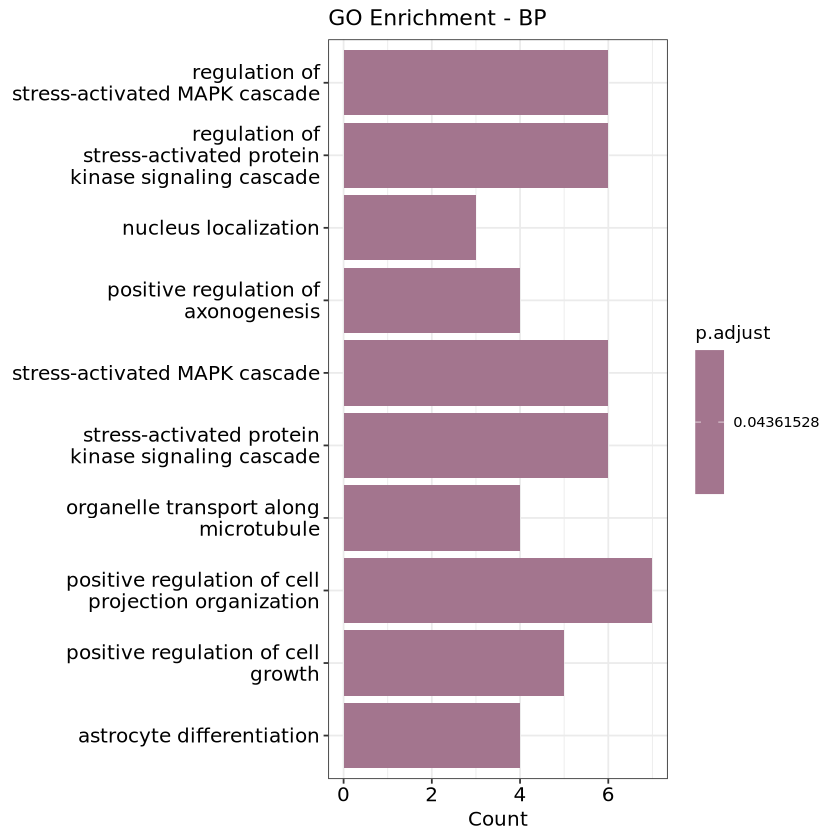

In [56]:
barplot(Aging3_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [57]:
Aging3_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_Aging3_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [58]:
head(Aging3_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0044754,GO:0044754,autolysosome,2/71,16/22568,0.001138104,0.1164340,0.1025519,ENSG00000225190/ENSG00000101460,2
GO:0044304,GO:0044304,main axon,3/71,81/22568,0.002135675,0.1164340,0.1025519,ENSG00000115306/ENSG00000136717/ENSG00000186868,3
GO:0005767,GO:0005767,secondary lysosome,2/71,23/22568,0.002365601,0.1164340,0.1025519,ENSG00000225190/ENSG00000101460,2
GO:0150034,GO:0150034,distal axon,5/71,295/22568,0.002376203,0.1164340,0.1025519,ENSG00000187164/ENSG00000149930/ENSG00000082482/ENSG00000136717/ENSG00000186868,5
GO:0030673,GO:0030673,axolemma,2/71,26/22568,0.003020360,0.1183981,0.1042819,ENSG00000115306/ENSG00000186868,2
GO:0044295,GO:0044295,axonal growth cone,2/71,30/22568,0.004009961,0.1309920,0.1153743,ENSG00000187164/ENSG00000149930,2
GO:0097386,GO:0097386,glial cell projection,2/71,45/22568,0.008853147,0.2478881,0.2183332,ENSG00000082482/ENSG00000186868,2
GO:0098978,GO:0098978,glutamatergic synapse,5/71,440/22568,0.012517245,0.2562680,0.2257140,ENSG00000102882/ENSG00000115306/ENSG00000136717/ENSG00000070831/ENSG00000101460,5
GO:1904115,GO:1904115,axon cytoplasm,2/71,66/22568,0.018386650,0.2562680,0.2257140,ENSG00000131966/ENSG00000186868,2


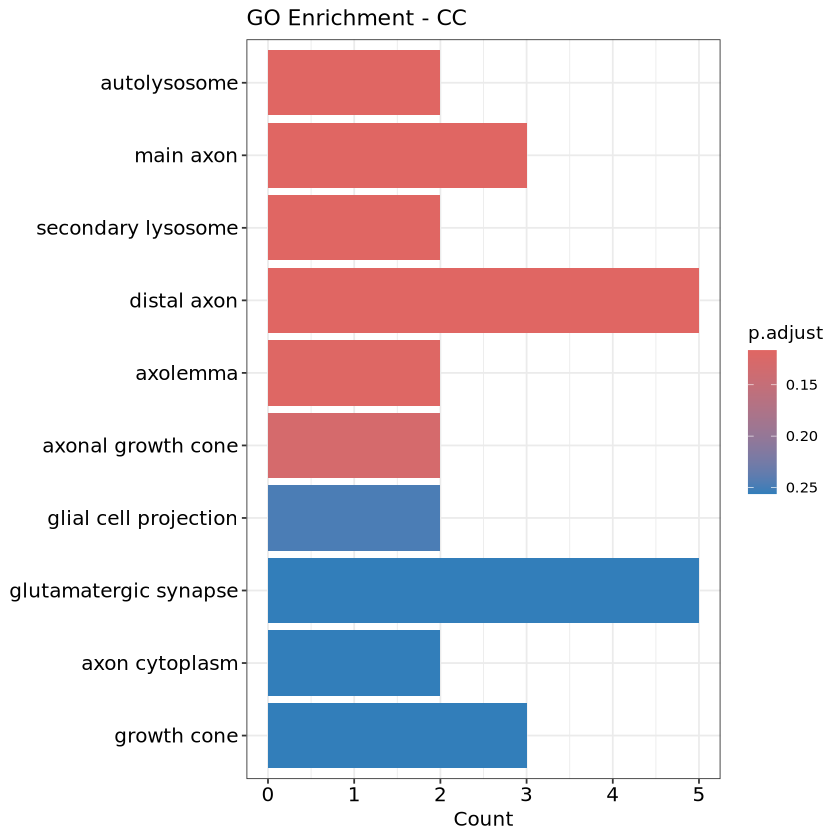

In [59]:
barplot(Aging3_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [60]:
image_Aging3_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_Aging3_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [61]:
head(image_Aging3_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0019902,GO:0019902,phosphatase binding,5/68,230/21059,0.0008864667,0.1687458,0.1448222,ENSG00000102882/ENSG00000147324/ENSG00000185950/ENSG00000186868/ENSG00000100991,5
GO:0004708,GO:0004708,MAP kinase kinase activity,2/68,18/21059,0.0015202326,0.1687458,0.1448222,ENSG00000102882/ENSG00000169032,2
GO:0051721,GO:0051721,protein phosphatase 2A binding,2/68,33/21059,0.0050850765,0.2282399,0.1958815,ENSG00000147324/ENSG00000186868,2
GO:0030295,GO:0030295,protein kinase activator activity,3/68,133/21059,0.0091533530,0.2282399,0.1958815,ENSG00000112715/ENSG00000169032/ENSG00000149930,3
GO:0048156,GO:0048156,tau protein binding,2/68,45/21059,0.0093001227,0.2282399,0.1958815,ENSG00000149930/ENSG00000136717,2
GO:0019209,GO:0019209,kinase activator activity,3/68,142/21059,0.0109297293,0.2282399,0.1958815,ENSG00000112715/ENSG00000169032/ENSG00000149930,3
GO:0004712,GO:0004712,protein serine/threonine/tyrosine kinase activity,2/68,49/21059,0.0109563071,0.2282399,0.1958815,ENSG00000102882/ENSG00000169032,2
GO:0017046,GO:0017046,peptide hormone binding,2/68,55/21059,0.0136645326,0.2282399,0.1958815,ENSG00000263715/ENSG00000120088,2
GO:0008017,GO:0008017,microtubule binding,4/68,289/21059,0.0142345107,0.2282399,0.1958815,ENSG00000214595/ENSG00000186868/ENSG00000101460/ENSG00000100242,4


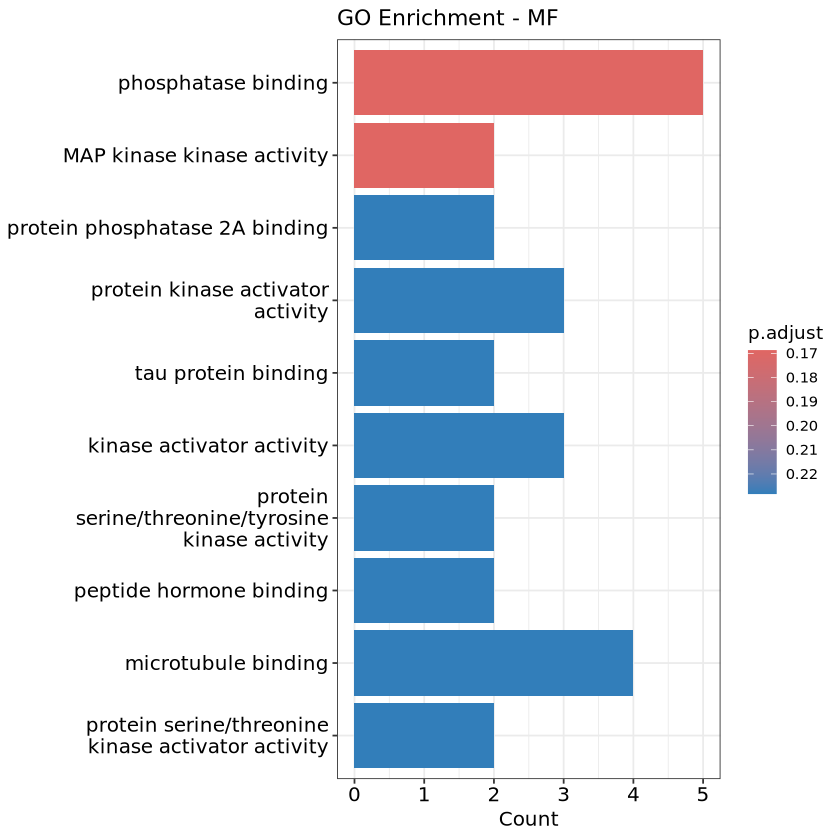

In [62]:
barplot(image_Aging3_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [15]:
entrez_ids <- bitr(image_Aging3_gene$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_Aging3_gene$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“1.3% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [21]:
kegg_enrich %>% head(n=15)
# kegg_enrich |> as.data.frame() %>% dplyr::slice(50:70)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04370,Environmental Information Processing,Signal transduction,hsa04370,VEGF signaling pathway,4/31,60/9446,4.071278e-05,0.006266835,0.003927496,5595/7422/5604/998,4
hsa05211,Human Diseases,Cancer: specific types,hsa05211,Renal cell carcinoma,4/31,70/9446,7.481949e-05,0.006266835,0.003927496,5595/7422/5604/998,4
hsa05212,Human Diseases,Cancer: specific types,hsa05212,Pancreatic cancer,4/31,77/9446,1.086734e-04,0.006266835,0.003927496,5595/7422/5604/998,4
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,5/31,169/9446,2.013730e-04,0.008709380,0.005458267,5595/5604/8660/9842/84557,5
hsa04666,Organismal Systems,Immune system,hsa04666,Fc gamma R-mediated phagocytosis,4/31,99/9446,2.874532e-04,0.009041278,0.005666271,5595/5604/274/998,4
hsa05219,Human Diseases,Cancer: specific types,hsa05219,Bladder cancer,3/31,41/9446,3.135703e-04,0.009041278,0.005666271,5595/7422/5604,3
hsa04010,Environmental Information Processing,Signal transduction,hsa04010,MAPK signaling pathway,6/31,300/9446,3.674094e-04,0.009080261,0.005690702,5595/7422/5604/9344/998/4137,6
hsa05205,Human Diseases,Cancer: overview,hsa05205,Proteoglycans in cancer,5/31,204/9446,4.809999e-04,0.010401623,0.006518814,5595/7422/5604/3339/998,5
hsa04730,Organismal Systems,Nervous system,hsa04730,Long-term depression,3/31,60/9446,9.650384e-04,0.018550182,0.011625608,5595/5604/1394,3


In [67]:
kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'lipid|Lipid|fatty|Fatty|Alzheimer|Cholesterol|phagy'))


,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,5/31,169/9442,0.0002017676,0.008726448,0.005468963,5595/5604/8660/9842/84557,5
hsa05010,Human Diseases,Neurodegenerative disease,hsa05010,Alzheimer disease,5/31,391/9442,0.0082866706,0.051199786,0.032087484,5595/5684/5604/8660/4137,5
hsa04932,Human Diseases,Endocrine and metabolic disease,hsa04932,Non-alcoholic fatty liver disease,3/31,157/9442,0.0144168046,0.069280755,0.043419031,83737/998/8660,3
hsa04071,Environmental Information Processing,Signal transduction,hsa04071,Sphingolipid signaling pathway,2/31,122/9442,0.0603737366,0.135644889,0.085010183,5595/5604,2
hsa00565,Metabolism,Lipid metabolism,hsa00565,Ether lipid metabolism,1/31,51/9442,0.1547858224,0.235692024,0.147710852,79153,1
hsa05417,Human Diseases,Cardiovascular disease,hsa05417,Lipid and atherosclerosis,2/31,216/9442,0.1576145865,0.237107161,0.148597734,5595/998,2
hsa04137,Cellular Processes,Transport and catabolism,hsa04137,Mitophagy - animal,1/31,105/9442,0.2933518933,0.331698546,0.207879223,84557,1


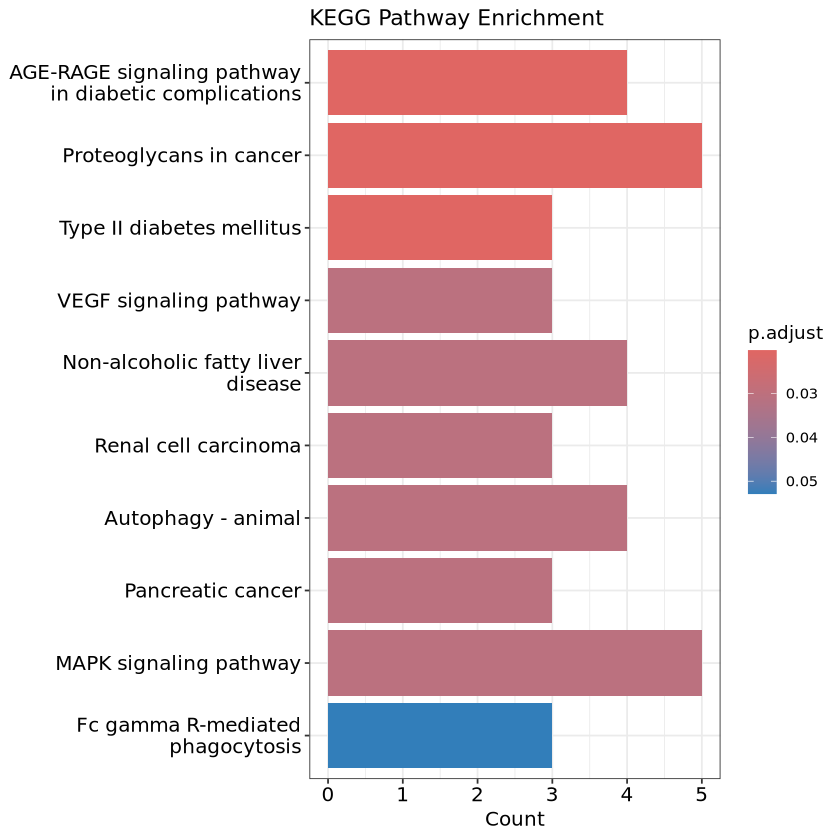

In [283]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")